# Model

In [37]:
%load_ext autoreload
%autoreload 2

import os

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [38]:
path_list = os.getcwd().split('\\')
if path_list[-1] == 'src':
    print(os.getcwd())
else:
    os.chdir('..')
    print(os.getcwd())

F:\study\Hackatons\DashboardSber\src


In [39]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
from datetime import datetime
pd.set_option('display.max_columns', None)

from prophet import Prophet
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import HDBSCAN, Birch, BisectingKMeans, KMeans, MeanShift
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

# Загрузка данных

In [40]:
def fix_date_columns(df):
    new_columns = [df.columns[0]]
    for column in df.columns[1:]:
        date = datetime.fromordinal(datetime(1900, 1, 1).toordinal() + int(column) - 2).strftime('%Y-%m-%d')
        new_columns.append(date)

    df.columns = new_columns
    return df


df_acquiring = pd.read_excel(
    io='dataset/acquiring.xlsb',
    engine='pyxlsb',
    header=1,  # У файла есть заголовок-объединение
    # nrows=1000,
)
df_acquiring = fix_date_columns(df_acquiring)

# df_rko = pd.read_excel(
#     io='dataset/rko.xlsb',
#     engine='pyxlsb',
#     header=1,  # У файла есть заголовок-объединение
# )
# df_rko = fix_date_columns(df_rko)

# df_economy_acquiring = pd.read_excel(
#     io='dataset/economy_acquiring.xlsb',
#     engine='pyxlsb',
#     header=1,  # У файла есть заголовок-объединение
# )

# df_economy_general = pd.read_excel(
#     io='dataset/economy_general.xlsb',
#     engine='pyxlsb',
#     header=1,  # У файла есть заголовок-объединение
# )

df_general = pd.read_excel(
    io='dataset/general.xlsb',
    engine='pyxlsb',
    header=0,  # У файла есть заголовок-объединение
)
df_general['Кластер'] = df_general['Кластер'].astype('category')
df_general = df_general.drop(['ОКВЭД, основная деятельность', 'ОКВЭД, дополнительные', 'Наименование основного ОКВЭД'], axis=1)
df_general

,клиент,Сегмент id,Кластер,Средний возраст работников,Тип организации,bank_1,bank_2,bank_3,bank_4,bank_5,bank_6,bank_7,bank_8,bank_9,bank_10,bank_11,bank_12,bank_13,bank_14,bank_15,bank_16,bank_17,bank_18,bank_19,bank_20,bank_21,bank_22,bank_23,bank_24,bank_25,bank_26,bank_27,bank_28,bank_29,bank_30,bank_31,bank_32,bank_33,bank_34,bank_35,bank_36,bank_37,bank_38,bank_39,bank_40,bank_41,bank_42,bank_43,bank_44,bank_45,bank_46,bank_47,bank_48,bank_49,bank_50,ns_promotion,acquiring_mobile,acreditiv,arenda_seyf,bank_straxovanie_imush,bank_straxovanie_lich,bank_straxovanie_otvet,broker,capital_markets,cash_management,dbo,dcd,deposit_sertificat,einvoicing,eko_docdoc,eko_interkomp,eko_korus,eko_sbermobile,eko_segmento,eko_tot,factoring,garantee_gos,garantee_kontract,garantee_other,invest_kredit,itog_bank,itog_eko,kbk,konversion,mb_a,ns_bukh,ns_business,ns_document,ns_in_app,nso,ns_priem_plat,ns_servis,ns_terminal,ns_torg,oborot_kredit,obsluzh_rts_rur,obsluzh_rts_val,overdraft_kredit,pfi,products_lizing,proekt_finans,spec_acc,us,veksel,bank_guarantees,credit,corporate_cards,valuta_control,deposit,inkass,acquiring_torg,rko,zarplat_projects,samoinkass,Компания в стадии ликвидации
0,client_5139,0,2,[40-48),ИП,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
1,client_16112,0,5,[0-27),ИП,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0
2,client_21152,0,5,[34-40),ИП,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
3,client_15302,0,1,[40-48),ИП,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,0,0
4,client_30885,0,6,>=48,ИП,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48418,client_21483,0,1,[27-34),ИП,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
48419,client_40397,0,1,[27-34),ИП,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,0,0
48420,client_4588,0,10,[40-48),ИП,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
48421,client_17159,0,1,>=48,ИП,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0


In [41]:
df_acquiring.head(3)

,клиент,2021-10-31,2021-11-30,2021-12-31,2022-01-31,2022-02-28,2022-03-31,2022-04-30,2022-05-31,2022-06-30,2022-07-31,2022-08-31,2022-09-30,2022-10-31,2022-11-30,2022-12-31,2023-01-31,2023-02-28,2023-03-31,2023-04-30,2023-05-31,2023-06-30,2023-07-31,2023-08-31,2023-09-30
0,client_37877,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1
1,client_30115,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1
2,client_9554,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


# Расчёт двух формул

In [42]:
def customer_churn_share(df: pd.DataFrame, end_id_month: int) -> float:
    """Доля оттока клиентов."""
    have_clients = df.iloc[:, end_id_month - 1]
    have_clients = have_clients[have_clients == 1]

    not_have_clients = df.iloc[have_clients.index, end_id_month]
    not_have_clients = not_have_clients[not_have_clients == 0]

    value = not_have_clients.shape[0] / have_clients.shape[0] * 100
    return value


customer_churn_share(df_acquiring, 2)

3.225806451612903

In [43]:
def customer_survival_rate(df: pd.DataFrame, end_id_month: int) -> float:
    """Расчет процента выживаемости клиентов"""
    start_clients = df.iloc[:, end_id_month - 1]
    start_clients = start_clients[start_clients == 1]

    left_clients = df.iloc[start_clients.index, end_id_month]
    left_clients = left_clients[left_clients == 0]

    df_copy = df.copy()
    df_copy = df_copy.drop(start_clients.index, axis=0)
    new_clients = df_copy.iloc[:, end_id_month]
    new_clients = new_clients[new_clients == 1]

    end_clients = start_clients.shape[0] - left_clients.shape[0] + new_clients.shape[0]
    value = ((end_clients - new_clients.shape[0]) / start_clients.shape[0]) * 100
    return value


customer_survival_rate(df_acquiring, 2)

96.7741935483871

# Feature Engineering

In [44]:
import pickle


def save_model(model: Prophet, filename: str) -> None:
    """Сохранение модели."""
    with open(filename, 'wb') as f:
        pickle.dump(model, f)

### Создание 3 таргетов

In [45]:
series_cols = df_acquiring.columns[df_acquiring.columns.str.contains("клиент")==False].values
level_cols = df_acquiring.columns[df_acquiring.columns.str.contains("клиент")].values

In [46]:
lst_customer_churn_share = [customer_churn_share(df_acquiring, i) for i in range(2, len(series_cols) + 1)]
len(lst_customer_churn_share)

23

In [47]:
lst_customer_survival_rate = [customer_survival_rate(df_acquiring, i) for i in range(2, len(series_cols) + 1)]
len(lst_customer_survival_rate)

23

In [48]:
df_cr_pr = pd.DataFrame(series_cols[1:], columns=["ds"])
df_cr_pr['ds'] = pd.to_datetime(df['ds'], format='%Y-%m-%d')
df_cr_pr.loc[:, "cr"] = lst_customer_churn_share
df_cr_pr.loc[:, "pr"] = lst_customer_survival_rate

df_cr_pr.loc[df_cr_pr.cr > 3, 'cr'] = df_cr_pr.cr.mean()
df_cr_pr.loc[df_cr_pr.pr < 88, 'pr'] = df_cr_pr.pr.mean()
df_cr_pr.head()

,ds,cr,pr
0,2021-10-31,2.221678,96.774194
1,2021-11-30,1.104972,98.895028
2,2021-12-31,1.104972,98.895028
3,2022-01-31,1.648352,98.351648
4,2022-02-28,1.111111,98.888889


# Модели

In [49]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score


def metrics(y_true, y_pred):

    rmse = mean_squared_error(y_true, y_pred, squared=False)
    print(f'{rmse = }')

    mae = mean_absolute_error(y_true, y_pred)
    print(f'{mae = }')

    r2 = r2_score(y_true, y_pred)
    print(f'{r2 = }')

In [50]:
# Про prophet:
# https://www.kaggle.com/code/prashant111/tutorial-time-series-forecasting-with-prophet

In [51]:
# Много моделей prophet с features:
# https://forecastegy.com/posts/multiple-time-series-forecasting-with-prophet-in-python/

In [52]:
TRAIN_END = -7

In [53]:
# timeseries = df_cr_pr.cr
# timeseries = df_cr_pr.pr
timeseries = df_acquiring[series_cols].sum().values

len(timeseries)

24

In [54]:
train_timeseries = timeseries[0:TRAIN_END]
eval_timeseries = timeseries[TRAIN_END::]
print(len(train_timeseries), len(eval_timeseries))

days = np.arange(1, len(train_timeseries) + len(eval_timeseries) + 1)
len(days)

17 7


24

In [55]:
df = pd.DataFrame(series_cols[len(series_cols) - len(days):], columns=["ds"])
df['ds'] = pd.to_datetime(df['ds'], format='%Y-%m-%d')
df.loc[:, "y"] = timeseries

df.loc[:, "cap"] = df.y.max()
df.loc[:, "floor"] = df.y.min()
# df.loc[:, "cap"] = 100
# df.loc[:, "floor"] = 0

print(df.shape)
df.tail()

(24, 4)


,ds,y,cap,floor
19,2023-05-31,7017,8546,159
20,2023-06-30,7852,8546,159
21,2023-07-31,8396,8546,159
22,2023-08-31,8511,8546,159
23,2023-09-30,8546,8546,159


In [56]:
df[['ds', 'y']].to_csv('data_cr_eq.csv', index=False)

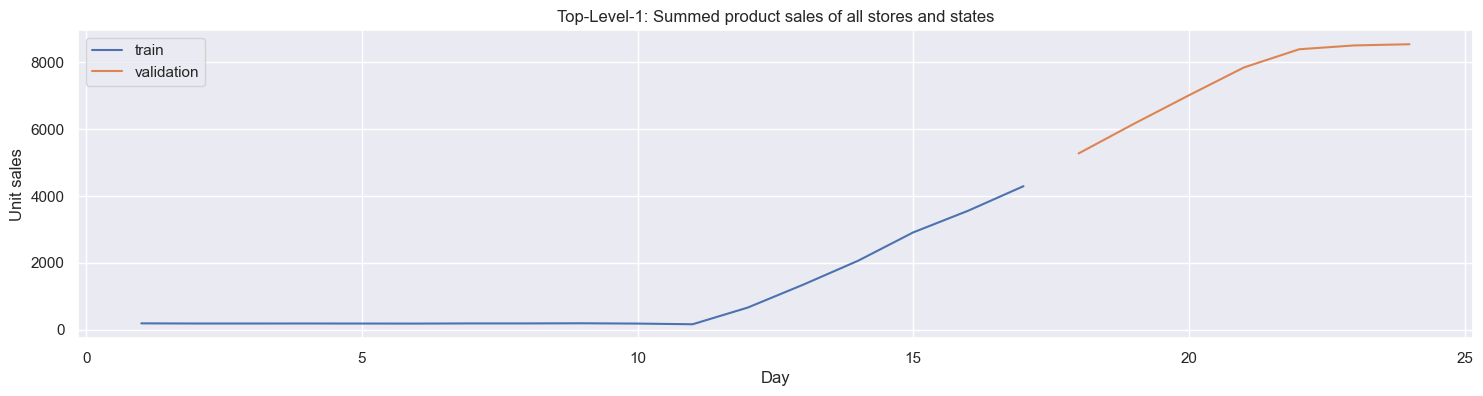

In [57]:
plt.figure(figsize=(18, 4))
plt.plot(days[0:TRAIN_END], train_timeseries, label="train")
plt.plot(days[TRAIN_END::], eval_timeseries, label="validation")
plt.title("Top-Level-1: Summed product sales of all stores and states");
plt.legend()
plt.xlabel("Day")
plt.ylabel("Unit sales");

In [58]:
train_df = df.iloc[0:TRAIN_END]
print(train_df.shape)

eval_df = df.iloc[TRAIN_END::]
print(eval_df.shape)

(17, 4)
(7, 4)


In [60]:
import optuna


def objective(trial):
    params = {
        'changepoint_prior_scale': trial.suggest_float("changepoint_prior_scale", 0.0001, 3.0),
        "seasonality_prior_scale": trial.suggest_int("seasonality_prior_scale", 1, 20),
        'growth':  trial.suggest_categorical("growth", ["logistic", "linear"]),
        "seasonality_mode": trial.suggest_categorical("seasonality_mode", ["additive", "multiplicative"]),
        # 'yearly_seasonality': trial.suggest_categorical("yearly_seasonality", [True, False]),
        # 'weekly_seasonality': trial.suggest_categorical("weekly_seasonality", [True, False]),
        'interval_width': trial.suggest_float("interval_width", 0.75, 0.95),
    }

    model = Prophet(**params)
    model.add_country_holidays('Russia')
    model.fit(train_df)

    pred = model.predict(eval_df)
    pred.index = eval_df.index

    rmse = mean_squared_error(pred.yhat, eval_df.y, squared=False)
    metrics(pred.yhat, eval_df.y)
    return rmse


study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=10)

print("Number of finished trials: ", len(study.trials))
print("Best trial:")
trial = study.best_trial
print("  Value: ", trial.value)
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

[I 2023-11-19 14:36:05,485] A new study created in memory with name: no-name-a46c3995-9217-41f7-8ef0-a79f8d9b028c
14:36:05 - cmdstanpy - INFO - Chain [1] start processing
14:36:06 - cmdstanpy - INFO - Chain [1] done processing
[I 2023-11-19 14:36:06,532] Trial 0 finished with value: 434.98747263668895 and parameters: {'changepoint_prior_scale': 2.3982084049504464, 'seasonality_prior_scale': 14, 'growth': 'logistic', 'seasonality_mode': 'multiplicative', 'interval_width': 0.7934332016828671}. Best is trial 0 with value: 434.98747263668895.


rmse = 434.98747263668895
mae = 362.0079640939547
r2 = 0.8019091891889802


14:36:06 - cmdstanpy - INFO - Chain [1] start processing
14:36:07 - cmdstanpy - INFO - Chain [1] done processing
[I 2023-11-19 14:36:07,120] Trial 1 finished with value: 525.2050563993276 and parameters: {'changepoint_prior_scale': 0.17116803253305712, 'seasonality_prior_scale': 11, 'growth': 'linear', 'seasonality_mode': 'multiplicative', 'interval_width': 0.9492127715674563}. Best is trial 0 with value: 434.98747263668895.


rmse = 525.2050563993276
mae = 468.97681708530087
r2 = 0.8770968709651599


14:36:07 - cmdstanpy - INFO - Chain [1] start processing
14:36:07 - cmdstanpy - INFO - Chain [1] done processing
[I 2023-11-19 14:36:07,960] Trial 2 finished with value: 406.9377222734679 and parameters: {'changepoint_prior_scale': 1.4065364680038375, 'seasonality_prior_scale': 6, 'growth': 'logistic', 'seasonality_mode': 'additive', 'interval_width': 0.9182977457018724}. Best is trial 2 with value: 406.9377222734679.


rmse = 406.9377222734679
mae = 335.9314303890486
r2 = 0.8257083537429732


14:36:08 - cmdstanpy - INFO - Chain [1] start processing
14:36:08 - cmdstanpy - INFO - Chain [1] done processing
[I 2023-11-19 14:36:08,559] Trial 3 finished with value: 525.3619342660589 and parameters: {'changepoint_prior_scale': 0.8735796074487892, 'seasonality_prior_scale': 12, 'growth': 'linear', 'seasonality_mode': 'additive', 'interval_width': 0.922122912496039}. Best is trial 2 with value: 406.9377222734679.


rmse = 525.3619342660589
mae = 468.15780959411416
r2 = 0.8772616595252201


14:36:08 - cmdstanpy - INFO - Chain [1] start processing
14:36:09 - cmdstanpy - INFO - Chain [1] done processing
[I 2023-11-19 14:36:09,408] Trial 4 finished with value: 382.4827853581284 and parameters: {'changepoint_prior_scale': 1.043529140751729, 'seasonality_prior_scale': 20, 'growth': 'logistic', 'seasonality_mode': 'multiplicative', 'interval_width': 0.8525655491888404}. Best is trial 4 with value: 382.4827853581284.


rmse = 382.4827853581284
mae = 312.085831866444
r2 = 0.8450706222197829


14:36:09 - cmdstanpy - INFO - Chain [1] start processing
14:36:09 - cmdstanpy - INFO - Chain [1] done processing
[I 2023-11-19 14:36:09,935] Trial 5 finished with value: 3890.33311112762 and parameters: {'changepoint_prior_scale': 0.1185744377698524, 'seasonality_prior_scale': 16, 'growth': 'linear', 'seasonality_mode': 'multiplicative', 'interval_width': 0.8459257504714237}. Best is trial 4 with value: 382.4827853581284.


rmse = 3890.33311112762
mae = 3809.6536295216056
r2 = -78.83588649936122


14:36:10 - cmdstanpy - INFO - Chain [1] start processing
14:36:10 - cmdstanpy - INFO - Chain [1] done processing
[I 2023-11-19 14:36:10,973] Trial 6 finished with value: 438.7527908670485 and parameters: {'changepoint_prior_scale': 2.6839853433355936, 'seasonality_prior_scale': 4, 'growth': 'logistic', 'seasonality_mode': 'additive', 'interval_width': 0.8019574058834438}. Best is trial 4 with value: 382.4827853581284.


rmse = 438.7527908670485
mae = 365.43244593835595
r2 = 0.7985831224984808


14:36:11 - cmdstanpy - INFO - Chain [1] start processing
14:36:11 - cmdstanpy - INFO - Chain [1] done processing
[I 2023-11-19 14:36:12,047] Trial 7 finished with value: 418.41074037804225 and parameters: {'changepoint_prior_scale': 1.740624667387609, 'seasonality_prior_scale': 15, 'growth': 'logistic', 'seasonality_mode': 'additive', 'interval_width': 0.8930911574331605}. Best is trial 4 with value: 382.4827853581284.


rmse = 418.41074037804225
mae = 346.72818374271145
r2 = 0.8161934883339175


14:36:12 - cmdstanpy - INFO - Chain [1] start processing
14:36:12 - cmdstanpy - INFO - Chain [1] done processing
[I 2023-11-19 14:36:12,873] Trial 8 finished with value: 408.63752654857524 and parameters: {'changepoint_prior_scale': 1.4512208941469658, 'seasonality_prior_scale': 8, 'growth': 'logistic', 'seasonality_mode': 'multiplicative', 'interval_width': 0.779338069445221}. Best is trial 4 with value: 382.4827853581284.


rmse = 408.63752654857524
mae = 337.54403557923484
r2 = 0.8243191594470327


14:36:13 - cmdstanpy - INFO - Chain [1] start processing
14:36:13 - cmdstanpy - INFO - Chain [1] done processing
[I 2023-11-19 14:36:13,833] Trial 9 finished with value: 440.157123856732 and parameters: {'changepoint_prior_scale': 2.8313842108703606, 'seasonality_prior_scale': 3, 'growth': 'logistic', 'seasonality_mode': 'multiplicative', 'interval_width': 0.8256094940531996}. Best is trial 4 with value: 382.4827853581284.


rmse = 440.157123856732
mae = 366.70394515286495
r2 = 0.7973408372039217
Number of finished trials:  10
Best trial:
  Value:  382.4827853581284
  Params: 
    changepoint_prior_scale: 1.043529140751729
    seasonality_prior_scale: 20
    growth: logistic
    seasonality_mode: multiplicative
    interval_width: 0.8525655491888404


In [62]:
# changepoint_prior_scale - используется для контроля гибкости тренда, чтобы избежать переобучения или недоподготовки

params_copy = study.best_trial.params.copy()

model = Prophet(**params_copy)
model.add_country_holidays('Russia')
# model = Prophet()
# model.fit(train_df)
model.fit(df)

# future = model.make_future_dataframe(periods=10, freq='M')
# pred = model.predict(future)
# for key, value in df.iloc[:, 4:].mean().items():
#     future[key] = value
# pred = model.predict(future)
# future['tmp'] = [np.random.randint(-50, 50) for i in range(future.shape[0])]

# pred = model.predict(eval_df)
# pred.index = eval_df.index

# metrics(pred.yhat, eval_df.y)

14:37:35 - cmdstanpy - INFO - Chain [1] start processing
14:37:36 - cmdstanpy - INFO - Chain [1] done processing


In [ ]:
save_model(model, 'model_cr_eq.pkl')

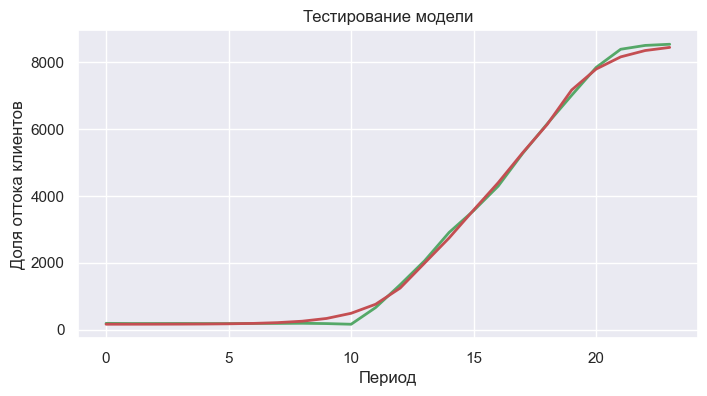

In [63]:
plt.figure(figsize=(8, 4))
plt.plot(df.y, "g", label="true", linewidth=2.0)
pred1 = model.predict(df)
pred1.index = df.index

plt.title('Тестирование модели')
plt.xlabel("Период")
plt.ylabel("Доля оттока клиентов")
plt.plot(pred1.yhat, "r", label="prediction", linewidth=2.0)

In [ ]:
model.plot(pred, figsize=(8, 4));

In [ ]:
model.plot_components(pred, figsize=(8, 4));